In [1]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

# Gestion du système de fichiers
import os
from os import listdir

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

2024-01-09 09:13:55.512743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [36]:
df = pd.read_csv('../Data/3.normalized_dataset_image.csv')
path = '../Data/AugmentedImages/'
df

,image_path,product_category_tree,label
0,aa68675f50a0551b8dadb954017a50a1.jpg,Kitchen & Dining,5
1,037c2402fee39fbc80433935711d1383.jpg,Home Furnishing,4
2,42643c1c9403f67921a18654bcf45ead.jpg,Baby Care,0
3,53f4bc7d7321f5c41de6b86e41f13e80.jpg,Home Decor & Festive Needs,3
4,b144a363c107c7bdd91f32d6e28ba6f2.jpg,Watches,6
...,...,...,...
1045,4e5ebfc871992e7e22365c0c036a1b89.jpg,Baby Care,0
1046,82fbc93cd45ab747e7e606f2c52c7335.jpg,Home Decor & Festive Needs,3
1047,216c6c3527984be3d7ad9023d5cd9bd1.jpg,Home Decor & Festive Needs,3
1048,f54d0c5cbd8e2270742293edf9075cb1.jpg,Home Furnishing,4


In [37]:
from glob import glob
import re

path = "../Data/SupervisedClassification/Images_train/"
path_test = "../Data/SupervisedClassification/Images_test/"

data_path = glob(path+'*.jp*')
data_test_path = glob(path_test+'*.jp*')

trainType = 'Images_train/'
testType = 'Images_test/'

def data_fct(path, type) :
    regular_express = r"^../Data/SupervisedClassification/"+type
    data = []

    for file in path:
        complet_file = file
        list_photos = re.sub(regular_express, "", complet_file)
        data.append(list_photos)
    df = pd.DataFrame(data, columns=['image_path'])
    return df


data = data_fct(data_path, trainType)
data_test = data_fct(data_test_path, testType)

data = pd.merge(data, df, on='image_path', how='left')
data_test = pd.merge(data_test, df, on='image_path', how='left')

In [42]:
batch_size = 32

def data_flow_fct(data, datagen, directory_path, data_type=None,) :
    data_flow = datagen.flow_from_dataframe(data, directory='../Data/SupervisedClassification/'+directory_path,
                                x_col='image_path', y_col='product_category_tree',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [43]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [45]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

directory_train = 'Images_train/'
directory_test = 'Images_test/'

train_flow = data_flow_fct(data, datagen_train, directory_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, directory_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, directory_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 596 validated image filenames belonging to 7 classes.
Found 198 validated image filenames belonging to 7 classes.
Found 256 validated image filenames belonging to 7 classes.


In [46]:
# Création du modèle
#with tf.device('/gpu:0'): 
model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [47]:
#with tf.device('/gpu:0'): 
    #print("Number of training samples:", len(train_flow))
    #print("Number of validation samples:", len(val_flow))

history2 = model2.fit(train_flow, validation_data=val_flow, batch_size=batch_size, epochs=10, callbacks=callbacks_list, verbose=1)

Epoch 1/10
19/19 [==============================] - ETA: 0s - loss: 4.3470 - accuracy: 0.4312
Epoch 1: val_loss improved from inf to 1.58215, saving model to ./model2_best_weights.h5
19/19 [==============================] - 156s 8s/step - loss: 4.3470 - accuracy: 0.4312 - val_loss: 1.5822 - val_accuracy: 0.7071
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 1.4928 - accuracy: 0.6762
Epoch 2: val_loss improved from 1.58215 to 1.45709, saving model to ./model2_best_weights.h5
19/19 [==============================] - 150s 8s/step - loss: 1.4928 - accuracy: 0.6762 - val_loss: 1.4571 - val_accuracy: 0.7020
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 1.1886 - accuracy: 0.7148
Epoch 3: val_loss improved from 1.45709 to 1.34654, saving model to ./model2_best_weights.h5
19/19 [==============================] - 150s 8s/step - loss: 1.1886 - accuracy: 0.7148 - val_loss: 1.3465 - val_accuracy: 0.7273
Epoch 4/10
19/19 [==============================] - E

In [48]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

19/19 [==============================] - 126s 6s/step - loss: 0.0750 - accuracy: 0.9748
Training Accuracy   : 0.9748

7/7 [==============================] - 38s 5s/step - loss: 1.2025 - accuracy: 0.7828
Validation Accuracy :  0.7828


In [49]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7980
Test Accuracy       :  0.8242


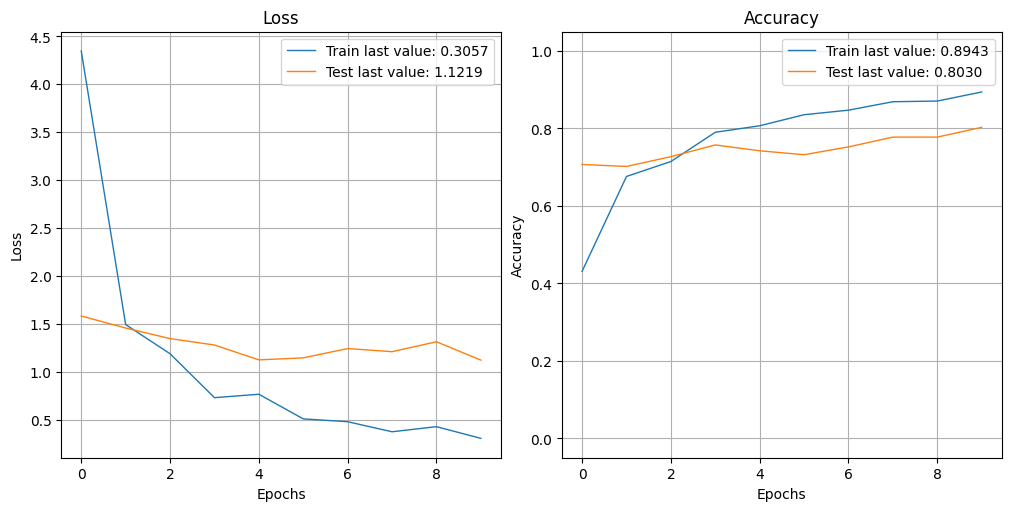

In [50]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plt.close()